In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import numpy as np
import uproot
import mplhep as hep
import awkward as ak
from numpy.core.function_base import linspace
import dask as dd
from scipy.optimize import curve_fit
import uncertainties.unumpy as unumpy
import nbconvert

hep.style.use('ATLAS')  # or ATLAS/LHCb2
plt.rcParams.update({'figure.max_open_warning': 0})
         
#FEBID=[22, 25, 17, 14, 20, 1]
FEBID=[25, 17]
NFEBS=len(FEBID)
NCHAN_FEB = 64
NCHAN_CMB = 4
SEC_YEAR=3.154e+7
MIN_TEMP=18
MAX_TEMP=21
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000-001ext.root"

In [2]:
from mu2etools import wideband

processor = wideband.DataProcessor(xroot=False, fixtimes=True)
ar, arSpills = processor.getData(DATASET)
df = ak.to_dataframe(ar) # entry - event, subentry - FEB, subsubentry - AFE
dfSpills = ak.to_dataframe(arSpills) # 

Temperature at CMB vs time

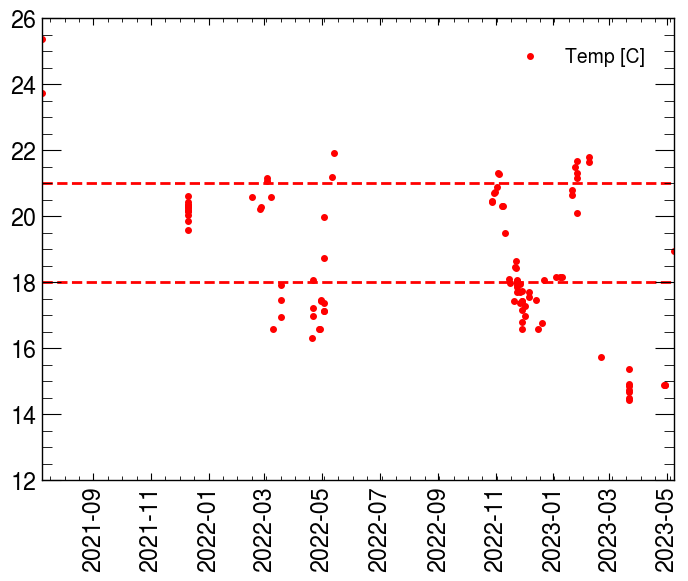

In [3]:
cut = (ar['timestamp'] > 0)
x=ar["timestamp", cut].to_numpy()
y=ar["meanTemperatures", cut][:,0,0].to_numpy()
    
plt.plot(x.astype('datetime64[s]'), y, 'r.', label='Temp [C]')
plt.xticks(rotation=90);
plt.legend()
plt.axhline(y=MAX_TEMP, color='r', linestyle='--')
plt.axhline(y=MIN_TEMP, color='r', linestyle='--');

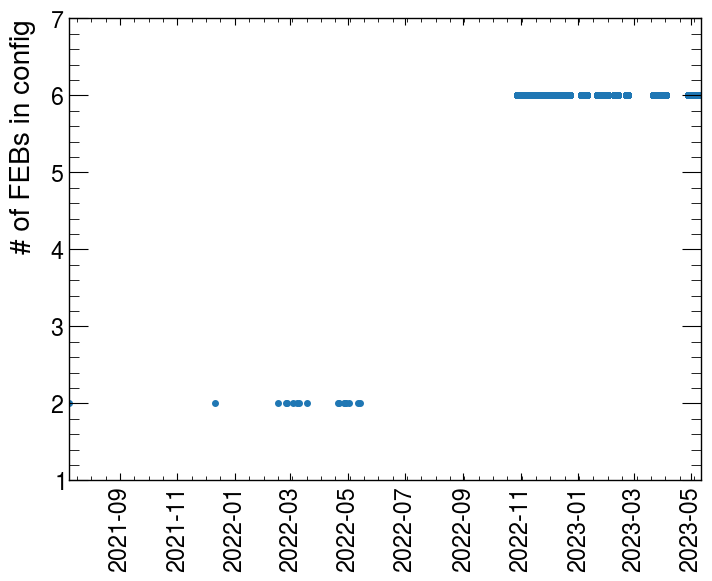

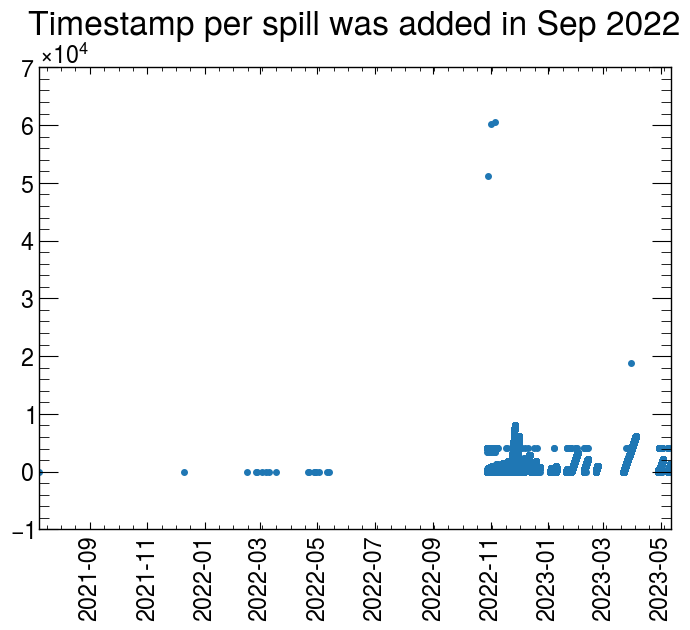

In [4]:
cut = (arSpills['spill_timestamp'] > 0)
x=arSpills["spill_timestamp", cut].to_numpy()
y=arSpills["spill_number_of_febs", cut].to_numpy()
    
plt.plot(x.astype('datetime64[s]'), y, '.')
plt.xticks(rotation = 90);
plt.ylabel('# of FEBs in config')

plt.figure()
y=arSpills["spill_num", cut].to_numpy()
plt.plot(x.astype('datetime64[s]'), y, '.')
plt.xticks(rotation = 90);
plt.title('Timestamp per spill was added in Sep 2022');

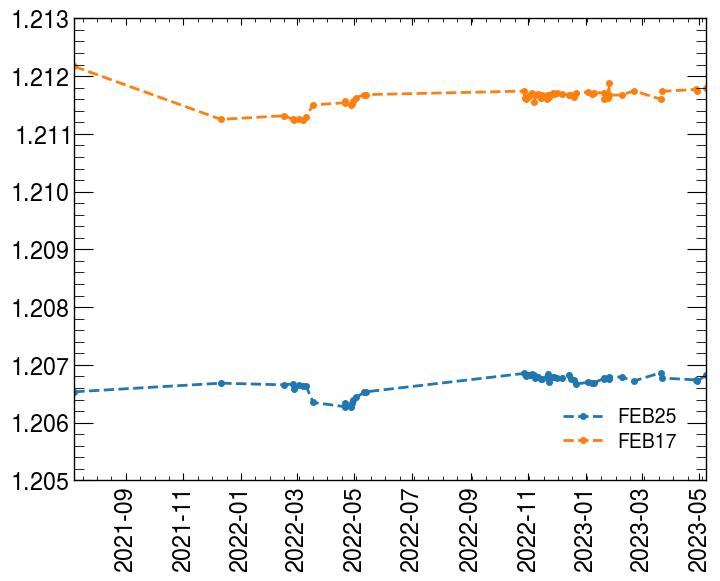

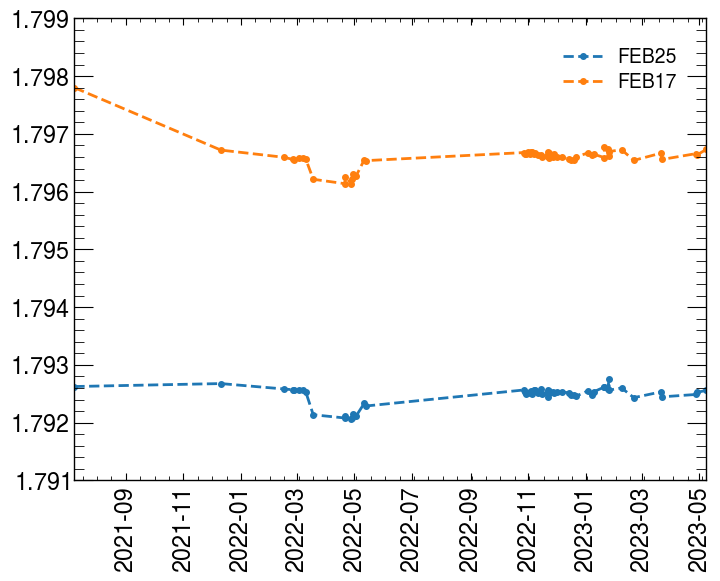

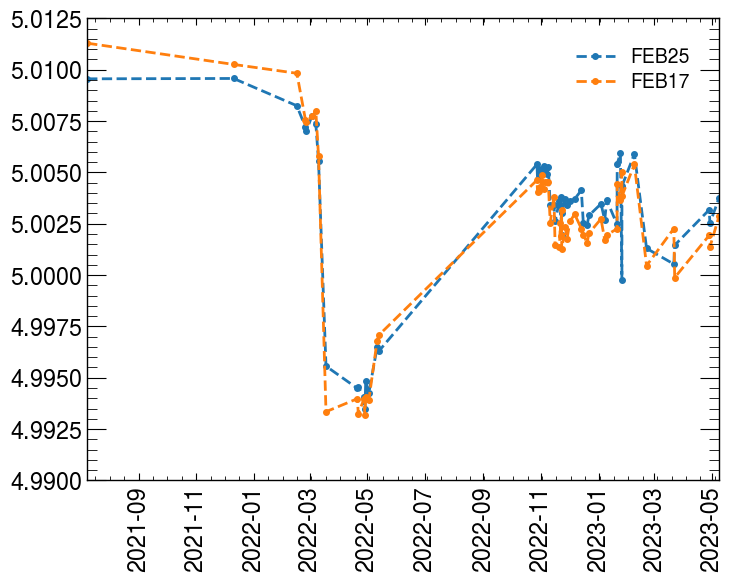

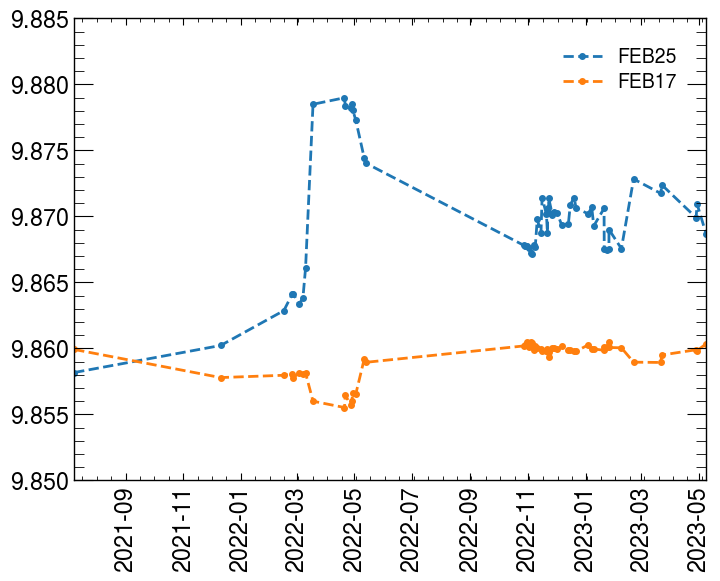

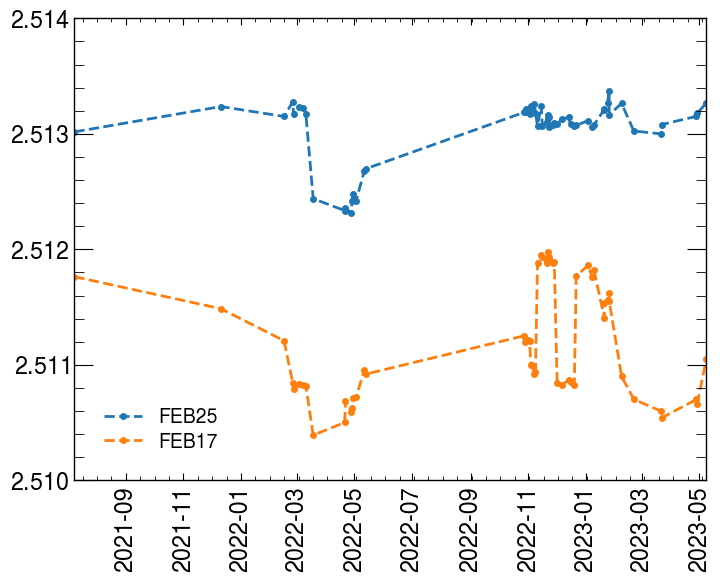

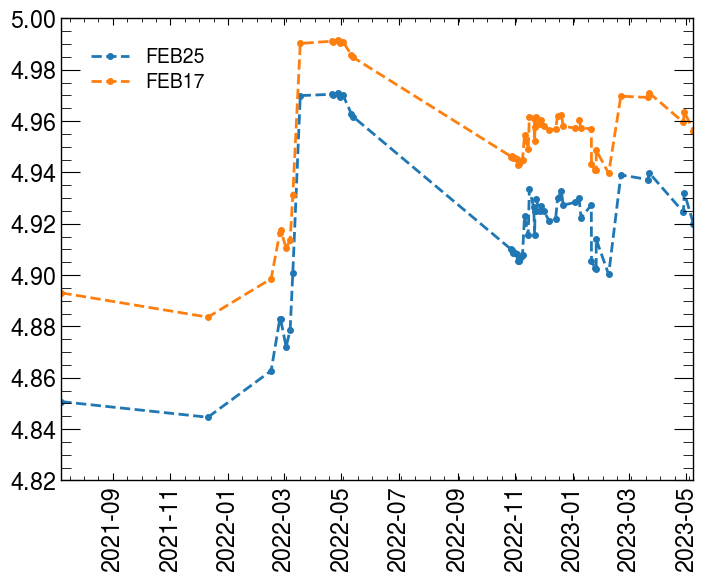

In [5]:
for volt in range(0,6):
    plt.figure()
    for feb in FEBID:
        x=df.query('subsubentry==%d & subrunNumber==0 & febID==%d'%(volt, feb))['timestamp'].to_numpy().astype('datetime64[s]')
        y=df.query('subsubentry==%d & subrunNumber==0 & febID==%d'%(volt, feb))['supplyMonitorsAvg'].to_numpy()
        plt.plot(x,y, '.--', label='FEB%d'%feb)
    plt.legend()
    plt.xticks(rotation = 90);    

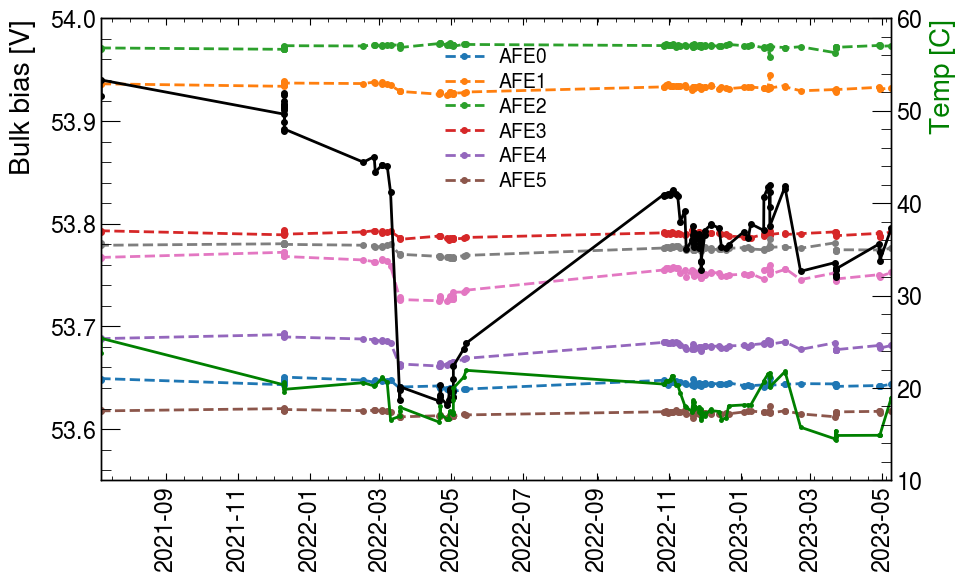

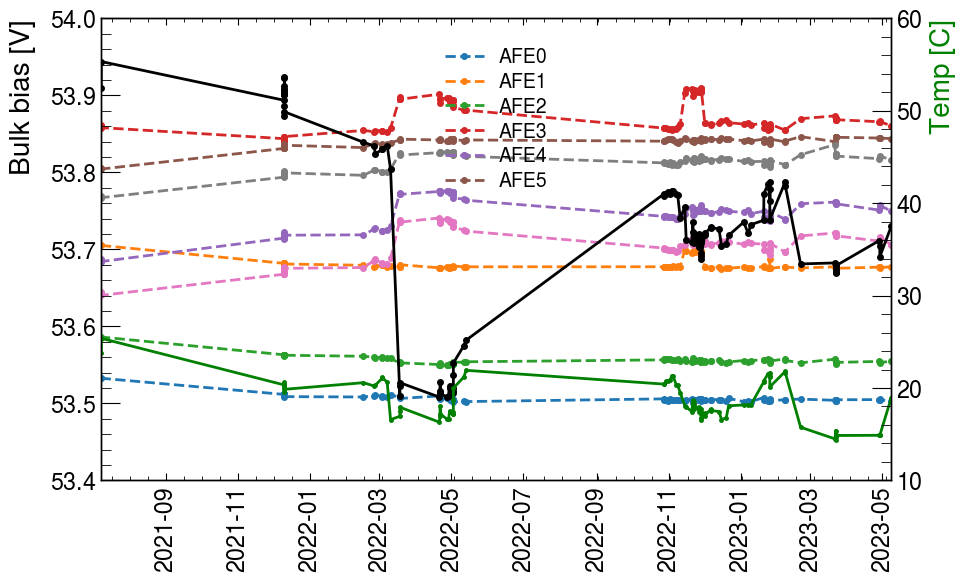

In [6]:
#for feb in FEBID:
for idx, feb in enumerate(FEBID):

    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation = 90);
    ax2 = ax1.twinx()
    
    cut = (ar['timestamp'] > 0)
    x=ar['timestamp', cut].to_numpy().astype('datetime64[s]')
    y=ar['biasVoltagesAvg', cut][:,idx,:].to_numpy()
    lineObjects = ax1.plot(x,y, '.--')    
    ax1.legend([f'AFE{i}' for i in range(0, 6)], loc='upper center')

    y=ar['febTemperaturesAvg', cut][:,idx].to_numpy()
    ax2.plot(x,y, 'k.-', label='FEB temp')
    ax1.set_ylabel('Bulk bias [V]')
    ax2.set_ylabel('Temp [C]')
    
    
    
    y=ar['meanTemperatures', cut][:,0,0].to_numpy()
    ax2.plot(x.astype('datetime64[s]'), y, 'g.-', markersize=5.0, label="CMB temb")
    ax2.set_ylabel('Temp [C]', color='g', labelpad=5)
    plt.xticks(rotation = 90);
    
#    plt.axvline(ar[ar['runNumber']==1176]['timestamp'].to_numpy().astype('datetime64[s]'), color='r', label="Install electronics rack")
#    ax2.legend(loc='upper right')


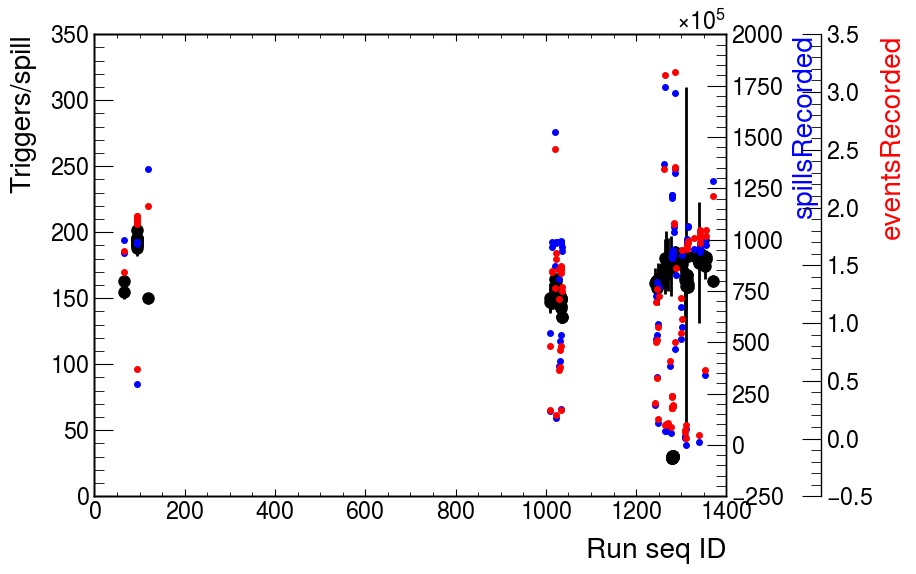

In [7]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.subplots_adjust(wspace=0.5)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.15))

x=len(ar['eventsRecorded'][:].to_numpy())

y1=ar['eventsRecorded'][:].to_numpy()
y1_std=np.sqrt(y1)
y1=unumpy.uarray(y1, y1_std) 

y2=ar['spillsRecorded'][:].to_numpy()
y2_std=np.sqrt(y2)
y2=unumpy.uarray(y2, y2_std) 

#x=linspace(0,x-1,x)
x=ar['runNumber'][:].to_numpy()

y=y1/y2

ax1.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt="o", color="k")
ax2.plot(x,ar['spillsRecorded'][:].to_numpy(), '.b')
ax3.plot(x,ar['eventsRecorded'][:].to_numpy(), '.r')

ax1.set_ylabel('Triggers/spill')
ax2.set_ylabel('spillsRecorded', color='b', labelpad=5)
ax3.set_ylabel('eventsRecorded', color='r', labelpad=5)
ax1.set_xlabel('Run seq ID');

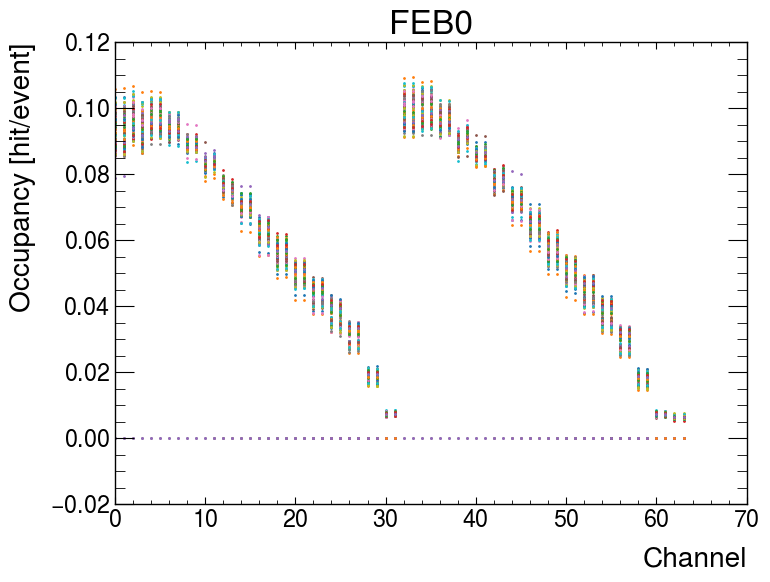

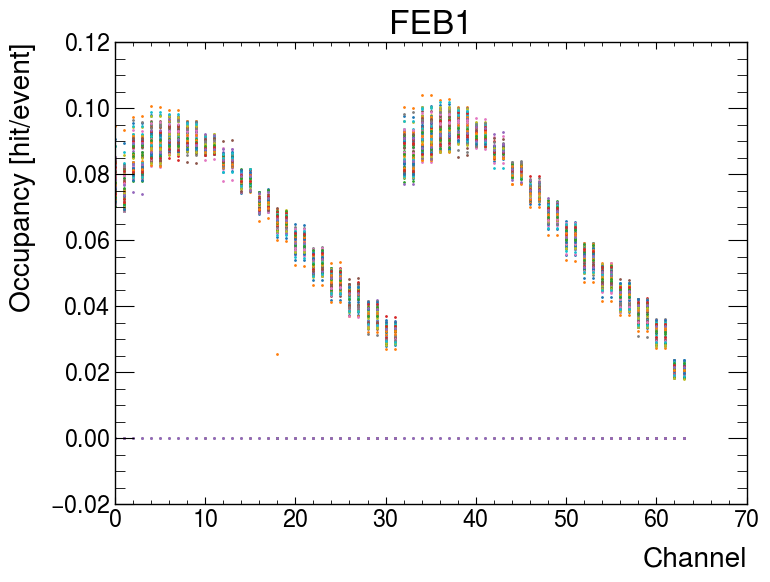

In [8]:
from numpy.core.function_base import linspace
for feb in range(0, NFEBS):
  plt.figure()
  for run in range(0,ak.count(ar['eventsRecorded'])):
    x=linspace(0,63,64)
    y=ar['signalsTemperatureCorrected'][run,feb,:].to_numpy()/ar['eventsRecorded'][run]
    plt.plot(x,y, '.', markersize=2, label='Run: %d'%run);
    plt.ylabel('Occupancy [hit/event]')
    plt.xlabel('Channel')
    plt.title('FEB%d'%feb)


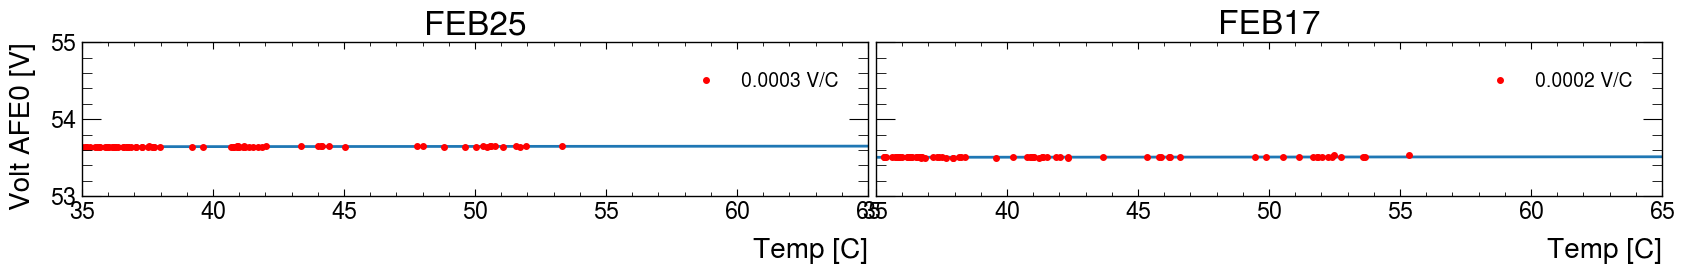

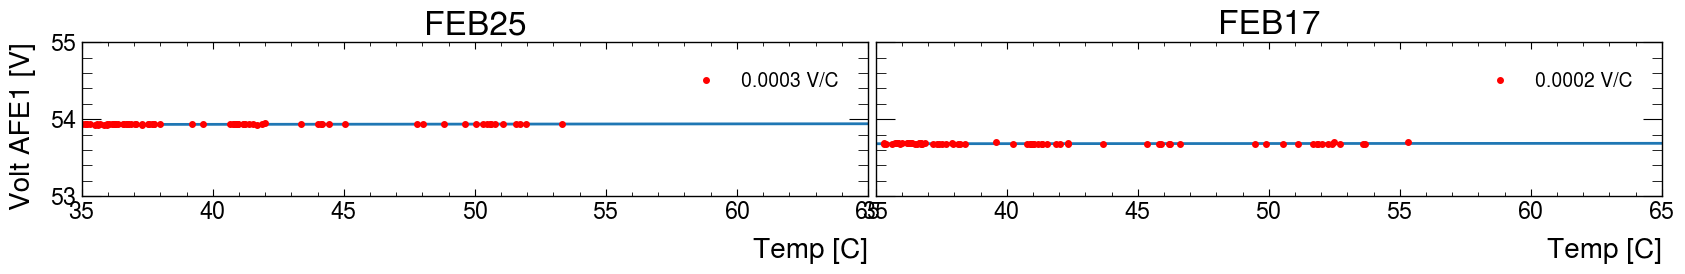

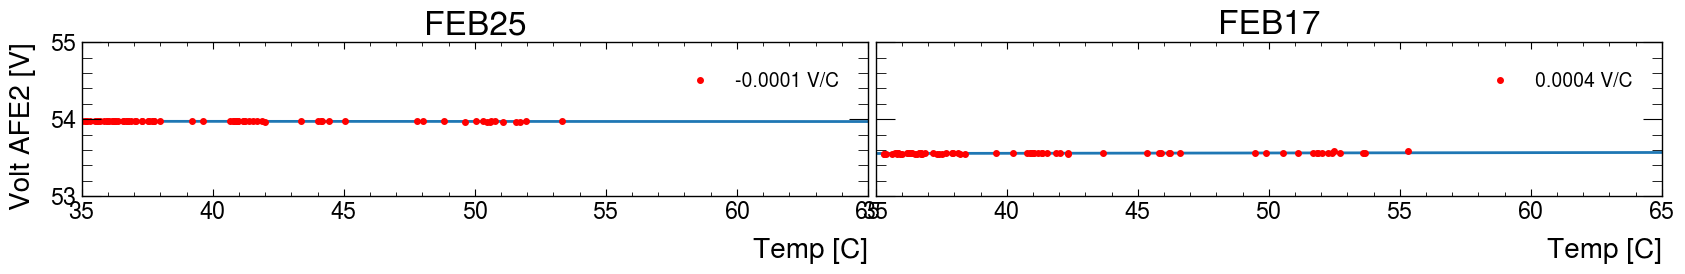

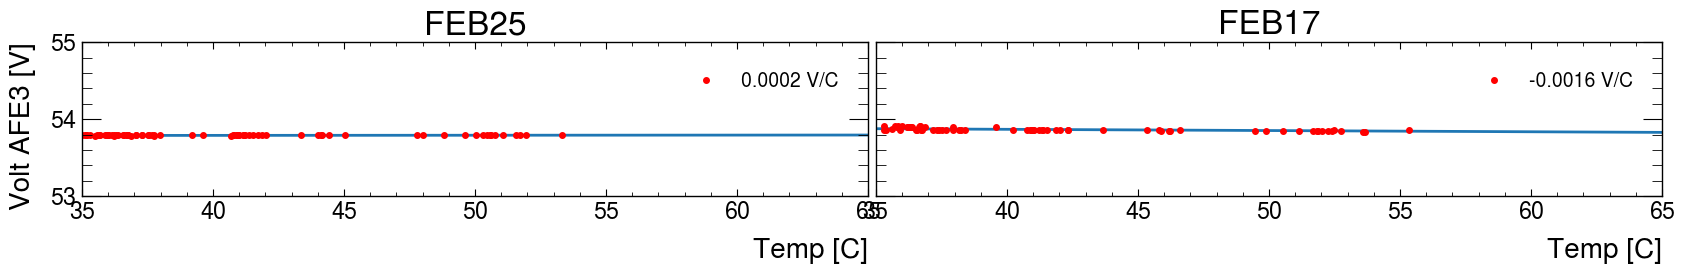

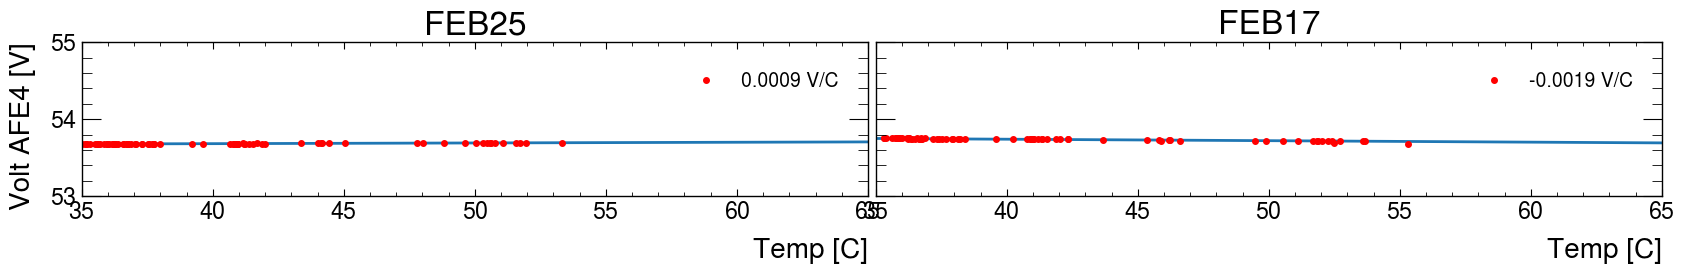

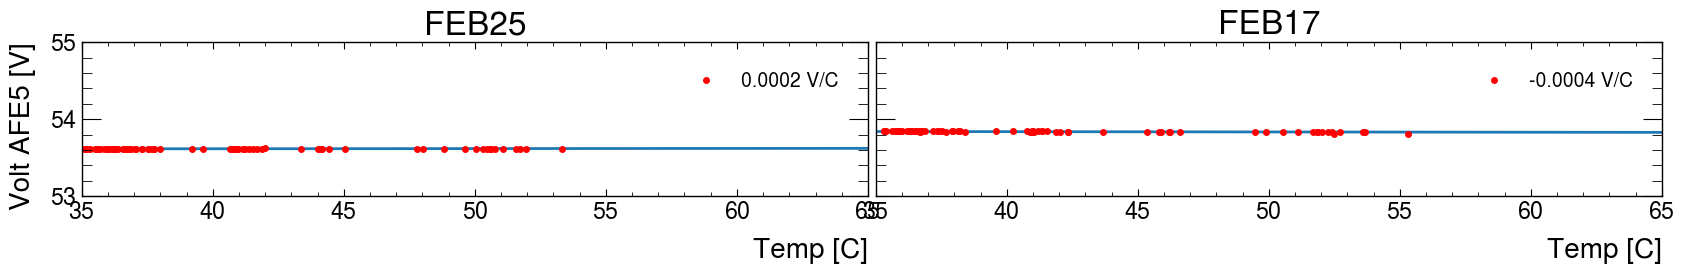

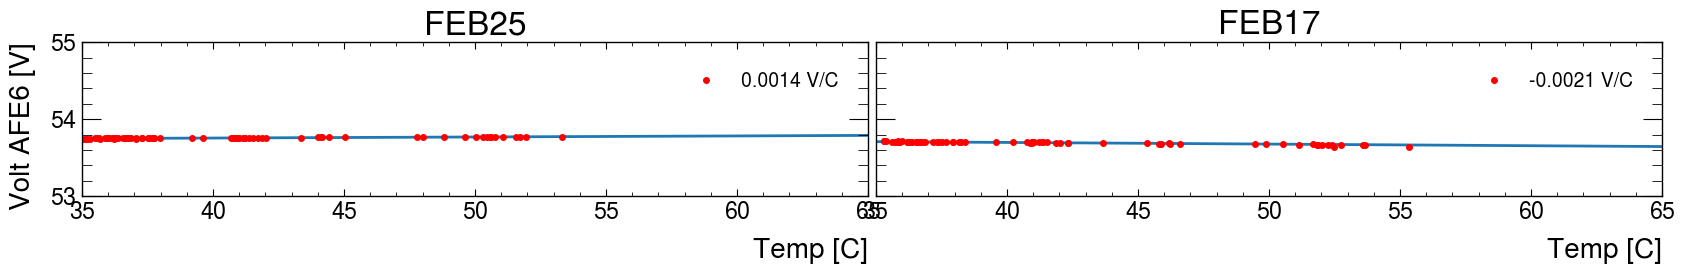

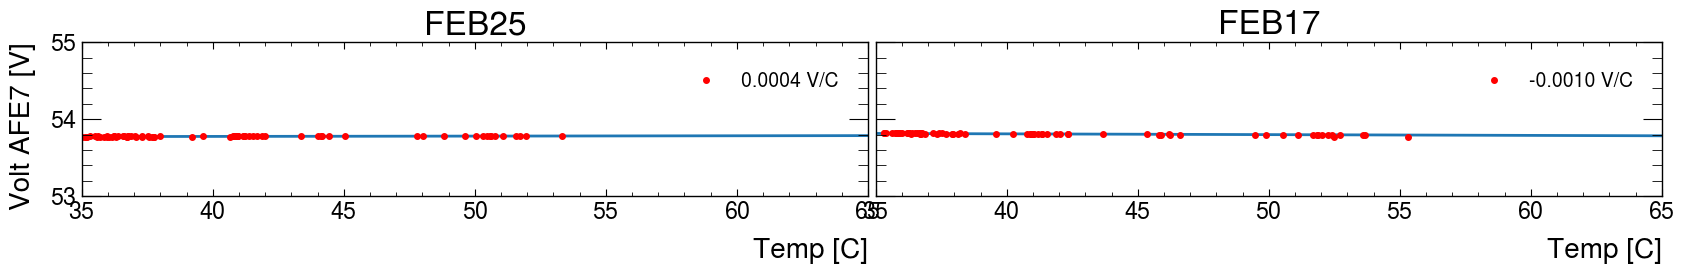

In [9]:
for i in range(0,8): # Loop thgough AFEs

    fig, ax1 = plt.subplots(nrows=1, ncols=NFEBS, figsize=(20, 2), sharey='row')
    plt.subplots_adjust(wspace=0.01)
    ax1[0].set_ylabel('Volt AFE%d [V]'%(i))


    for idx, feb in enumerate(FEBID):

        cut = (ar['febID'] == feb)
        x=ar["febTemperaturesAvg", cut]
        y=ar["biasVoltagesAvg", cut]

        x=x[x > 0].to_numpy().flatten()    
        y=y[ak.num(y) > 0].to_numpy().squeeze()[:,i]
        
        linmodel = np.poly1d(np.polyfit(x, y, 1))
        xline = np.linspace(35, 65, 100)
        ax1[idx].plot(xline, linmodel(xline))
        ax1[idx].plot(x,y,'r.', label='%.4f V/C'%linmodel.coeffs[0])

        ax1[idx].set_xlabel('Temp [C]')

        ax1[idx].set_xlim(35,65)
        ax1[idx].set_ylim(53,55)
        ax1[idx].legend()
        ax1[idx].set_title('FEB%d'%feb)

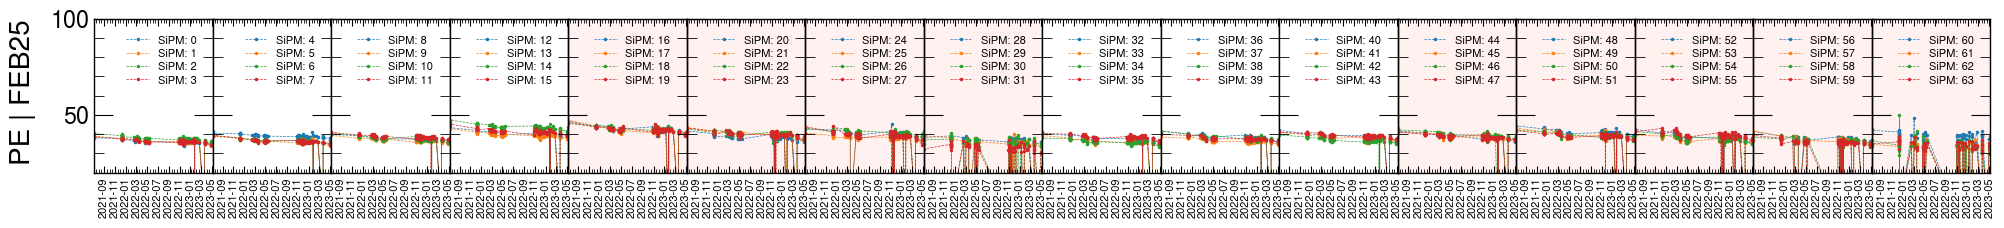

In [ ]:
for idx, feb in enumerate(FEBID):

    fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey='row')
    plt.subplots_adjust(wspace=0)
    axes[0].set_ylabel('PE | FEB%d'%feb)

    for chan in range(NCHAN_FEB): # Loop thgough hdmi

        sipm = chan % 4
        ax = axes[chan//4]    
        x = ar['timestamp'].to_numpy().astype('datetime64[s]')
        y = ar['PEsTemperatureCorrected'][:, idx, chan]            
        ax.plot(x, y, '.--', linewidth=0.5, markersize=3, label='SiPM: %d' % chan)
        ax.set_ylim(20, 100)
        ax.legend(prop={'size': 8}, loc='upper right')
                
        if ak.count(y[y<0.1])>3: # Tag bad channels red FIXME
            ax.set_facecolor((1.0, 0.47, 0.42,0.1))
        for tick in axes[chan//4].get_xticklabels():
            tick.set_rotation(90)
            tick.set_fontsize(8)

In [ ]:
for idx, feb in enumerate(FEBID):

    fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey='row')
    plt.subplots_adjust(wspace=0)
    axes[0].set_ylabel('PE | FEB%d'%feb)

    for chan in range(NCHAN_FEB): # Loop thgough hdmi

        sipm = chan % 4
        ax = axes[chan//4]    
        x = ar['timestamp'].to_numpy().astype('datetime64[s]')
        y = ar['PEs'][:, idx, chan]            
        ax.plot(x, y, '.--', linewidth=0.5, markersize=3, label='SiPM: %d' % chan)
        ax.set_ylim(20, 100)
        ax.legend(prop={'size': 8}, loc='upper right')
                
        if ak.count(y[y<0.1])>3: # Tag bad channels red FIXME
            ax.set_facecolor((1.0, 0.47, 0.42,0.1))
        for tick in axes[chan//4].get_xticklabels():
            tick.set_rotation(90)
            tick.set_fontsize(8)

In [ ]:
# Define the exponential function to fit
def func(x, a, b):
    return a * np.exp(-b*x/100) # return aging rate in %
#    return a -b*x/100 # return aging rate in %

df_age = pd.DataFrame(columns=['age_rate', 'age_rate_std', 'res_std', 'chi2', 'chan', 'feb'])

#Filter only data within a narrow temperature range
cut=(ar['meanTemperatures'][:, 0, 0]>MIN_TEMP) & (ar['meanTemperatures'][:, 0, 0]<MAX_TEMP)
ar_=ar[cut]

for feb in range(0, NFEBS):
    
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))
    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation=90)    
    
    for chan_infeb in range(NCHAN_FEB):

        chan = chan_infeb%NCHAN_CMB
        cut = (ar_['PEsTemperatureCorrected'][:, feb, chan_infeb] > 0)
        y = ar_['PEsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
        if len(y) == 0:
            continue

        y = y / y[0]
        t0 = ar_['timestamp', cut][0]
        x = (ar_['timestamp', cut] - t0)/SEC_YEAR
        x = x.to_numpy()

        popt, pcov = curve_fit(func, x, y, p0=[1, 5])
        
        a, age_rate = popt
        y_fit = func(x, a, age_rate)

        age_rate_std = np.sqrt(np.diag(pcov))[1] # Aging rate error 
        residuals = y - y_fit
        res_std = np.std(residuals)
        chisq = np.sum(residuals**2)
        dof = len(x) - len(popt)
        reduced_chi2 = chisq/dof
        
        # Plot only first 4 channels from FEBs
        if chan_infeb < 4:
            ax1[chan].set_title('chan: %d, feb: %d, aging: %.1f%% $\pm$ %.1f'%(chan_infeb,feb,age_rate,age_rate_std))
            ax1[chan].plot(x, y_fit, 'r-', linewidth=1, label='Fit')
            ax1[chan].set_ylim(0.8, 1.05)
            ax1[chan].set_ylabel('PEs', color='r')
            ax1[chan].set_xlabel('Years since T0')
            ax1[chan].tick_params(axis='y', which='both', colors='r')
            ax1[chan].tick_params(axis='x', rotation=90)
            ax1[chan].plot(x, y, 'ro')

            y = ar_['calibConstantsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
            ax2.plot(x, y, 'k.--', linewidth=1)
            ax2.set_ylim(100, 600)
            ax2.set_ylabel('SPE', color='k')

            y = ar_['meanTemperatures', cut][:, 0, 0].to_numpy()
            ax3.plot(x, y, 'go', markersize=5.0)
            ax2 = ax1[chan].twinx()
            ax3 = ax1[chan].twinx()
            ax3.spines['right'].set_position(("axes", 1.18))
            ax3.set_ylabel('Temp [C]', color='g')
            ax3.set_ylim(15, 27)
            ax3.tick_params(axis='y', which='both', colors='g')

        #fill dataframe
        new_row = {'age_rate': age_rate, 'age_rate_std':age_rate_std, 'res_std':res_std, 'chi2':reduced_chi2, 'chan':chan_infeb, 'feb':feb}
        df_age.loc[len(df_age)] = new_row
        
df_age['chi2_norm'] = df_age['chi2']/(df_age['res_std']**2).mean()

In [ ]:
x=df_age['chi2_norm']
plt.hist(x, histtype='step', bins=100, range=(0,5), label="<Chi2>: %.2f"%x.mean());
plt.legend()

plt.figure()
x=df_age.query('chi2_norm<1.5')['age_rate']
plt.hist(x, histtype='step', bins=100, label="<Aging rate>: %.2f"%x.mean());
plt.legend()

plt.figure()
x=df_age.query('chi2_norm<1.5')['age_rate_std']
plt.hist(x, histtype='step', bins=100, label="<Aging rate error>: %.2f"%x.mean());
plt.legend();

In [ ]:
for feb in range(0,NFEBS):
    x=df_age.query('chi2_norm<1.5 & feb==%d'%feb)['age_rate']
    plt.hist(x, histtype='step', range=(-5,15), bins=40, label='feb: %d, rate: %0.1f%% $\pm$ %.1f%%'%(feb,x.mean(),x.std()));
plt.xlabel('Aging rate')

x=df_age.query('chi2_norm<1.5')['age_rate']
plt.hist(x, histtype='step', range=(-5,15), bins=40, label='All febs, rate: %0.1f%% $\pm$ %.1f%%'%(x.mean(),x.std()));
plt.legend();


plt.figure()
for feb in range(0,NFEBS):
    x=df_age.query('feb==%d'%feb)['chan']
    y=df_age.query('feb==%d'%feb)['age_rate']
    plt.plot(x, y, '.', label='feb: %d'%feb);
plt.legend();
plt.xlabel('Channel ID')
plt.ylim(-15,15);

In [ ]:
df_tempPE = pd.DataFrame(columns=['slope', 'offset', 'chan', 'feb'])
ar_ = ar[ar['runNumber']>1176] # Select only data after electronics rack was installed

for idx, feb in enumerate(FEBID):

    fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey='row')
    plt.subplots_adjust(wspace=0)
    axes[0].set_ylabel('PE | FEB%d'%feb)

    for chan in range(NCHAN_FEB): # Loop thgough hdmi

        sipm = chan % 4
        ax = axes[chan//4]    
        x = ar_['meanTemperatures'][:, idx, chan].to_numpy()
        y = ar_['PEsTemperatureCorrected'][:, idx, chan].to_numpy()
        x=x[y > 0] # Drop bad SPE points 
        y=y[y > 0] # Drop bad SPE points
        if len(x) == 0: # Drop dead channels
            continue
        
        linmodel = np.poly1d(np.polyfit(x, y, 1))
        xline = np.linspace(17, 25, 100)
        ax.plot(xline, linmodel(xline), 'r--', linewidth=0.5)
        ax.plot(x,y, '.', linewidth=0.5, markersize=3, label='Ch%d: %.2f'%(chan, linmodel.coeffs[0]))
        ax.set_xlabel('Temp [C]', fontsize=10)
        ax.set_ylim(20, 100)
        ax.set_xlim(16, 27)
        ax.legend(prop={'size': 8}, loc='upper right')
        new_row = {'slope': linmodel.coeffs[0], 'offset': linmodel.coeffs[1], 'chan':chan, 'feb':feb}
        df_tempPE.loc[len(df_tempPE)] = new_row
        
plt.figure()
for feb in FEBID:
    df_ = df_tempPE.query('feb==%d'%feb)
    plt.plot(df_['chan'], df_['slope'], '.')
    plt.ylabel('Slope')
    plt.xlabel('Chan ID')

plt.figure()
plt.plot(df_tempPE['slope'], df_tempPE['offset'], '.');
plt.xlabel('Slope [PE/C]');
plt.ylabel('Offset [PE]');

In [ ]:
df_tempPE = pd.DataFrame(columns=['slope', 'offset', 'chan', 'feb'])
ar_ = ar[ar['runNumber']>1176] # Select only data after electronics rack was installed

for idx, feb in enumerate(FEBID):

    fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey='row')
    plt.subplots_adjust(wspace=0)
    axes[0].set_ylabel('SPE | FEB%d'%feb)

    for chan in range(NCHAN_FEB): # Loop thgough hdmi

        sipm = chan % 4
        ax = axes[chan//4]    
        x = ar_['meanTemperatures'][:, idx, chan].to_numpy()
        y = ar_['calibConstantsTemperatureCorrected'][:, idx, chan].to_numpy()
        x=x[y > 0] # Drop bad SPE points 
        y=y[y > 0] # Drop bad SPE points
        if len(x) == 0: # Drop dead channels
            continue
        
        linmodel = np.poly1d(np.polyfit(x, y, 1))
        xline = np.linspace(17, 25, 100)
        ax.plot(xline, linmodel(xline), 'r--', linewidth=0.5)
        ax.plot(x,y, '.', linewidth=0.5, markersize=3, label='Ch%d: %.2f'%(chan, linmodel.coeffs[0]))
        ax.set_xlabel('Temp [C]', fontsize=10)
        ax.set_xlim(16, 27)
        ax.legend(prop={'size': 8}, loc='upper right')
        new_row = {'slope': linmodel.coeffs[0], 'offset': linmodel.coeffs[1], 'chan':chan, 'feb':feb}
        df_tempPE.loc[len(df_tempPE)] = new_row
        
plt.figure()
for feb in FEBID:
    df_ = df_tempPE.query('feb==%d'%feb)
    plt.plot(df_['chan'], df_['slope'], '.')
    plt.ylabel('Slope')
    plt.xlabel('Chan ID')
    
plt.figure()    
plt.plot(df_tempPE['slope'], df_tempPE['offset'], '.');
plt.xlabel('Slope [ADC*ns/C]');
plt.ylabel('Offset [ADC*ns]');

In [ ]:
# Set the print options to display comma-separated values
np.set_printoptions(formatter={'float': lambda x: "{:,.0f}".format(x)})

df_tempPE = pd.DataFrame(columns=['slope', 'offset', 'chan', 'feb'])
ar_ = ar[ar['runNumber']>1176] # Select only data after electronics rack was installed

for idx, feb in enumerate(FEBID):

    fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey='row')
    plt.subplots_adjust(wspace=0)
    axes[0].set_ylabel('SPE | FEB%d'%feb)

    for chan in range(NCHAN_FEB): # Loop thgough hdmi

        sipm = chan % 4
        ax = axes[chan//4]    
        x = ar_['meanTemperatures'][:, idx, chan].to_numpy()
        y = ar_['calibConstants'][:, idx, chan].to_numpy()

        x=x[y > 0] # Drop bad SPE points 
        y=y[y > 0] # Drop bad SPE points
        
        y=y[x > 0] # Drop bad Temp points
        x=x[x > 0] # Drop bad Temp points 
        
        if len(x) == 0: # Drop dead channels
            continue

        linmodel = np.poly1d(np.polyfit(x, y, 1))
        xline = np.linspace(17, 25, 100)
        ax.plot(xline, linmodel(xline), 'r--', linewidth=0.5)
        ax.plot(x,y, '.', linewidth=0.5, markersize=3, label='Ch%d: %.2f'%(chan, linmodel.coeffs[0]))
        ax.set_xlabel('Temp [C]', fontsize=10)
        ax.set_xlim(16, 27)
        ax.legend(prop={'size': 8}, loc='upper right')
        new_row = {'slope': linmodel.coeffs[0], 'offset': linmodel.coeffs[1], 'chan':chan, 'feb':feb}
        df_tempPE.loc[len(df_tempPE)] = new_row
        
plt.figure()
for feb in FEBID:
    df_ = df_tempPE.query('feb==%d'%feb)
    plt.plot(df_['chan'], df_['slope'], '.')
    plt.ylabel('Slope')
    plt.xlabel('Chan ID')
    
plt.figure()    
for feb in FEBID:
    df_ = df_tempPE.query('feb==%d'%feb)
    plt.plot(df_['slope'], df_['offset'], '.', label='FEB%d'%feb);
    plt.xlabel('Slope [ADC*ns/C]');
    plt.ylabel('Offset [ADC*ns]');
plt.legend();

In [ ]:
plt.plot(ar['meanTemperatures'][0, :, :], '.k');
plt.xlabel('FEB');
plt.ylabel('Temp [C]');
plt.ylim(18, 25);
plt.plot(np.mean(ar['meanTemperatures'][0, :, :].to_numpy(), axis=1), 'or')

In [ ]:
import datetime
current_time = datetime.datetime.now()
print("Current time:", current_time)

In [ ]:
import nbformat
from nbformat import v4

notebook_filename = 'Aging_Conf-007.ipynb' 
# Get the current notebook as a notebook node
current_notebook = nbformat.v4.reads(open(notebook_filename, 'r').read())

# Save the notebook to a file
nbformat.write(current_notebook, 'aging_nb/%s.ipynb'%DATASET.split(".")[3])